In [1]:
# !pip install mlxtend
# !pip install numpy scipy pandas scikit-learn
# !pip install seaborn

In [2]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
# from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import color
import seaborn as sns
import pandas as pd


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [4]:
img_size = (100, 100)  # Poți ajusta dimensiunea după necesitate
batch_size = 32

# Directorul de antrenare și testare
base_path = os.path.join(path, "fruits-360_dataset_100x100", "fruits-360")
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Test")


In [5]:
# Generatoare de date
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Încărcarea imaginilor
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [6]:
X_train = np.concatenate([train_generator[i][0] for i in range(len(train_generator))], axis=0)
X_test = np.concatenate([test_generator[i][0] for i in range(len(test_generator))], axis=0)


# Obține primul lot de imagini și etichete
images, labels = train_generator[0]
class_names = list(train_generator.class_indices.keys())
# plt.figure(figsize=(20, 20))
# for i in range(len(images)):
#     plt.subplot(8, 4, i+1)
#     plt.imshow(images[i])
#     label = np.argmax(labels[i])
#     plt.title(class_names[label])
#     plt.axis('off')
# plt.show()


In [7]:
Y_train = np.concatenate([train_generator[i][1] for i in range(len(train_generator))], axis=0)
Y_test = np.concatenate([test_generator[i][1] for i in range(len(test_generator))], axis=0)

In [23]:
print(train_generator[0][1])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [8]:
pca = PCA(n_components=10)


X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_pca = pca.fit_transform(X_train_flat)

X_test_pca = pca.transform(X_test_flat)

In [9]:


# Funcție pentru a aplica HOG pe un set de imagini
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Conversie în grayscale pentru HOG
        gray_img = color.rgb2gray(img)
        features, _ = hog(gray_img, orientations=6, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

# Extragem atributele HOG din datele de antrenare

X_train_hog = extract_hog_features(X_train)

# Vizualizare dimensiune atribute
print(f"Dimensiunea atributelor HOG: {X_train_hog.shape}")

Dimensiunea atributelor HOG: (70491, 216)


In [16]:
X_test_hog = extract_hog_features(X_test)

## 4.2

<Figure size 2000x800 with 0 Axes>

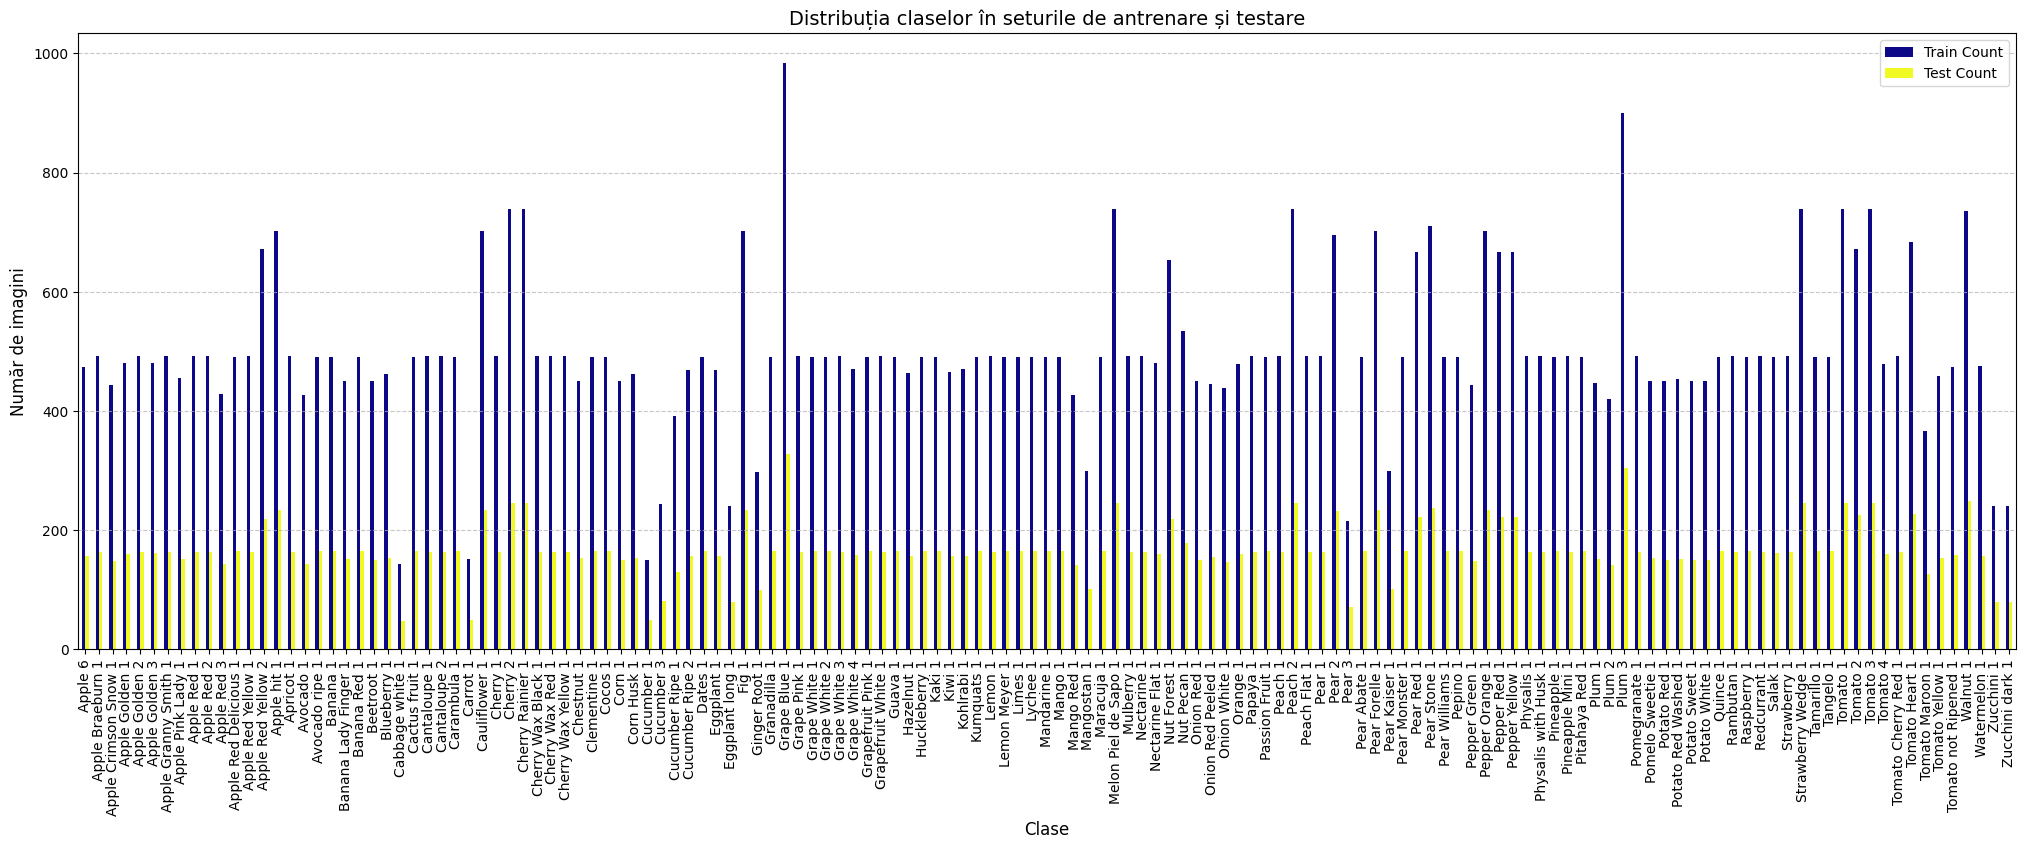

In [10]:
labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

test_class_names = list(test_generator.class_indices.keys())
test_labels = test_generator.classes

# Creare DataFrame pentru distribuția claselor în setul de antrenare
df_train = pd.DataFrame({'Label': labels})
class_distribution_train = df_train['Label'].value_counts().sort_index()

# Creare DataFrame pentru distribuția claselor în setul de testare
df_test = pd.DataFrame({'Label': test_labels})
class_distribution_test = df_test['Label'].value_counts().sort_index()

# Combinare distribuții într-un singur DataFrame
combined_df = pd.DataFrame({
    'Class': class_names,
    'Train Count': class_distribution_train.values,
    'Test Count': class_distribution_test.values
})

# Vizualizare distribuții
plt.figure(figsize=(20, 8))
combined_df.set_index('Class').plot(kind='bar', colormap='plasma', figsize=(25, 8))
plt.xticks(rotation=90, fontsize=10)
plt.title('Distribuția claselor în seturile de antrenare și testare', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Număr de imagini', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


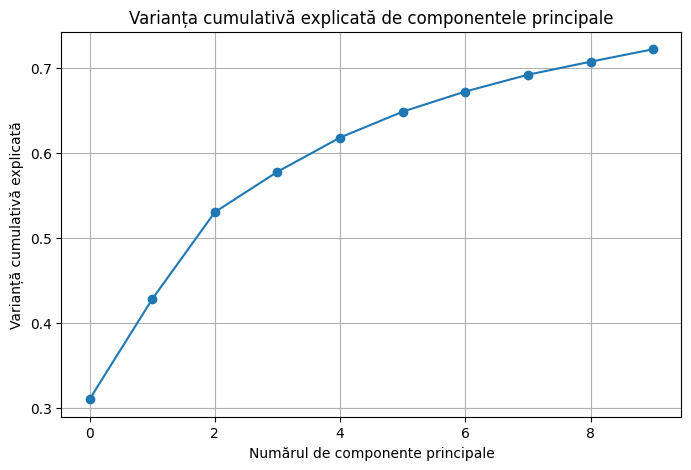

In [11]:


img_size = (100, 100)  # Înlocuiește cu dimensiunea reală a imaginilor tale

# Extragem toate imaginile din generator
# Extragem datele din generator


# Vizualizăm varianța cumulativă explicată
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Varianța cumulativă explicată de componentele principale")
plt.xlabel("Numărul de componente principale")
plt.ylabel("Varianță cumulativă explicată")
plt.grid()
plt.show()



In [ ]:
top_10_classes = combined_df.sort_values(by='Train Count', ascending=False).head(10)['Class'].values


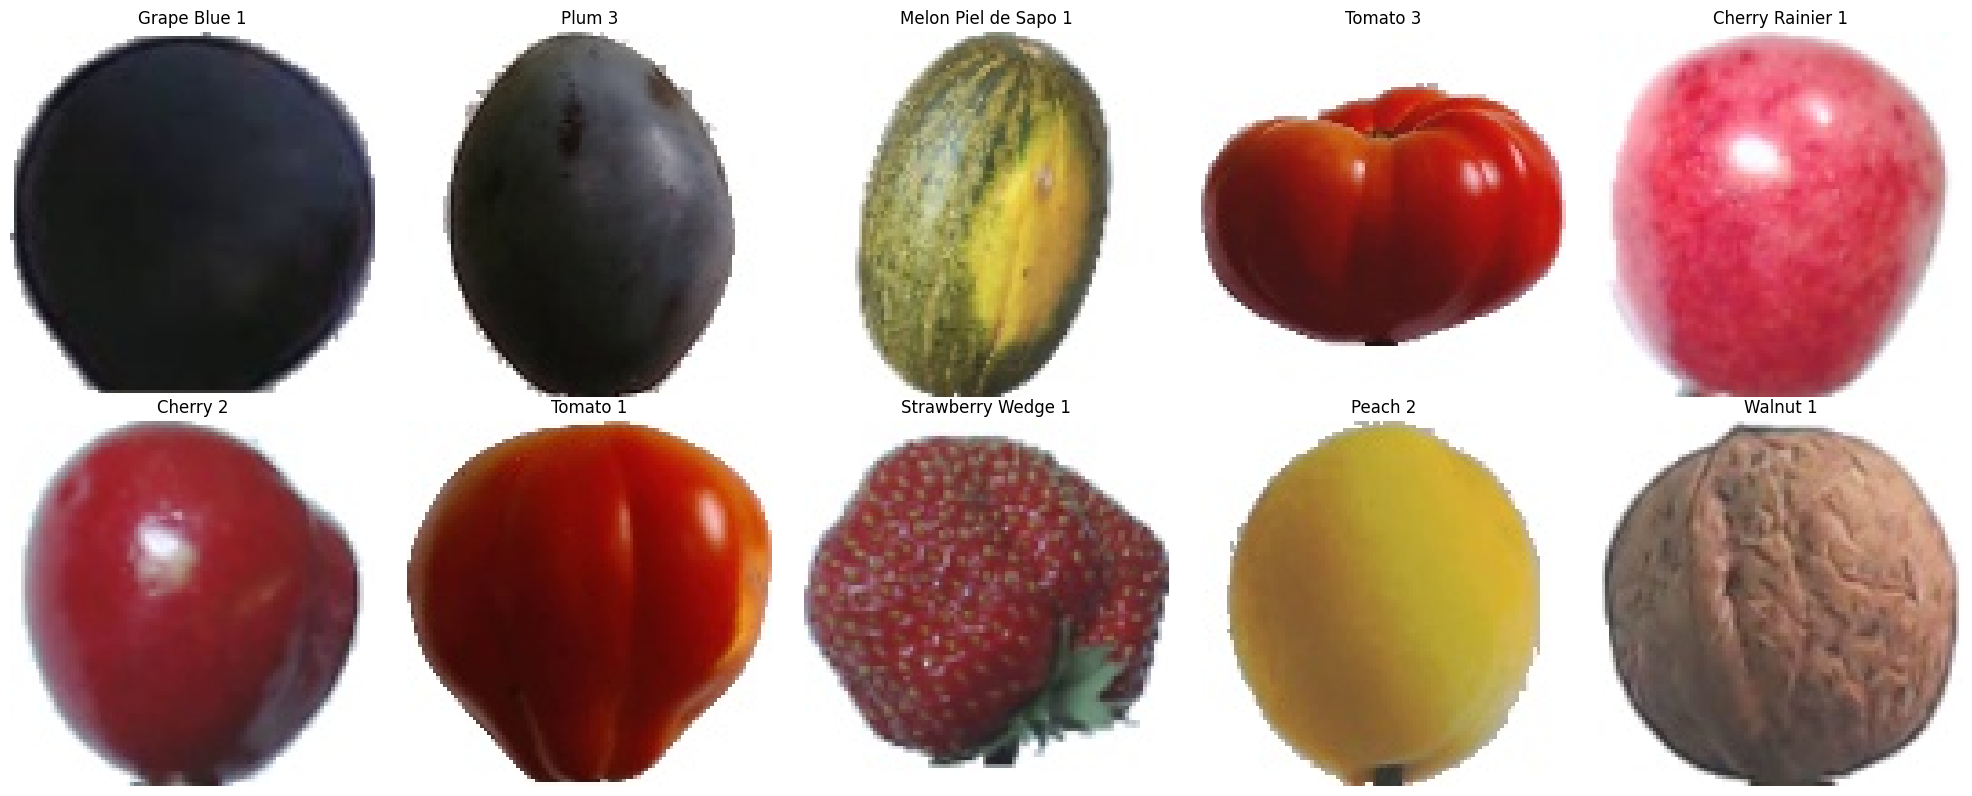

Indici imagini selectate: [(750, 19, 51), (1730, 29, 112), (1123, 3, 75), (2034, 20, 130), (485, 2, 32), (462, 0, 31), (1990, 18, 128), (1936, 28, 125), (1331, 23, 88), (2150, 1, 137)]


In [12]:
# Selectăm primele 10 clase cele mai numeroase

# Listă pentru a salva indicii imaginilor
image_indices = []
original_images = []
# Afișăm câte o imagine din fiecare clasă
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, class_name in enumerate(top_10_classes):
    # Găsim indexul clasei
    class_index = class_names.index(class_name)
    
    # Găsim prima imagine din această clasă
    a = 0
    for batch in train_generator:
        a += 1
        images, labels = train_generator[a]
        class_indices = np.where(labels[:, class_index] == 1)[0]
        if len(class_indices) > 0:
            img = train_generator[a][0][class_indices[0]]# images[class_indices[0]] 
            image_indices.append((a, class_indices[0], class_index))
            break
      # Salvăm indexul imaginii și batch_index
    # Afișăm imaginea
    axes[i].imshow(img)
    original_images.append(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Afișăm indicii imaginilor selectate
print("Indici imagini selectate:", image_indices)


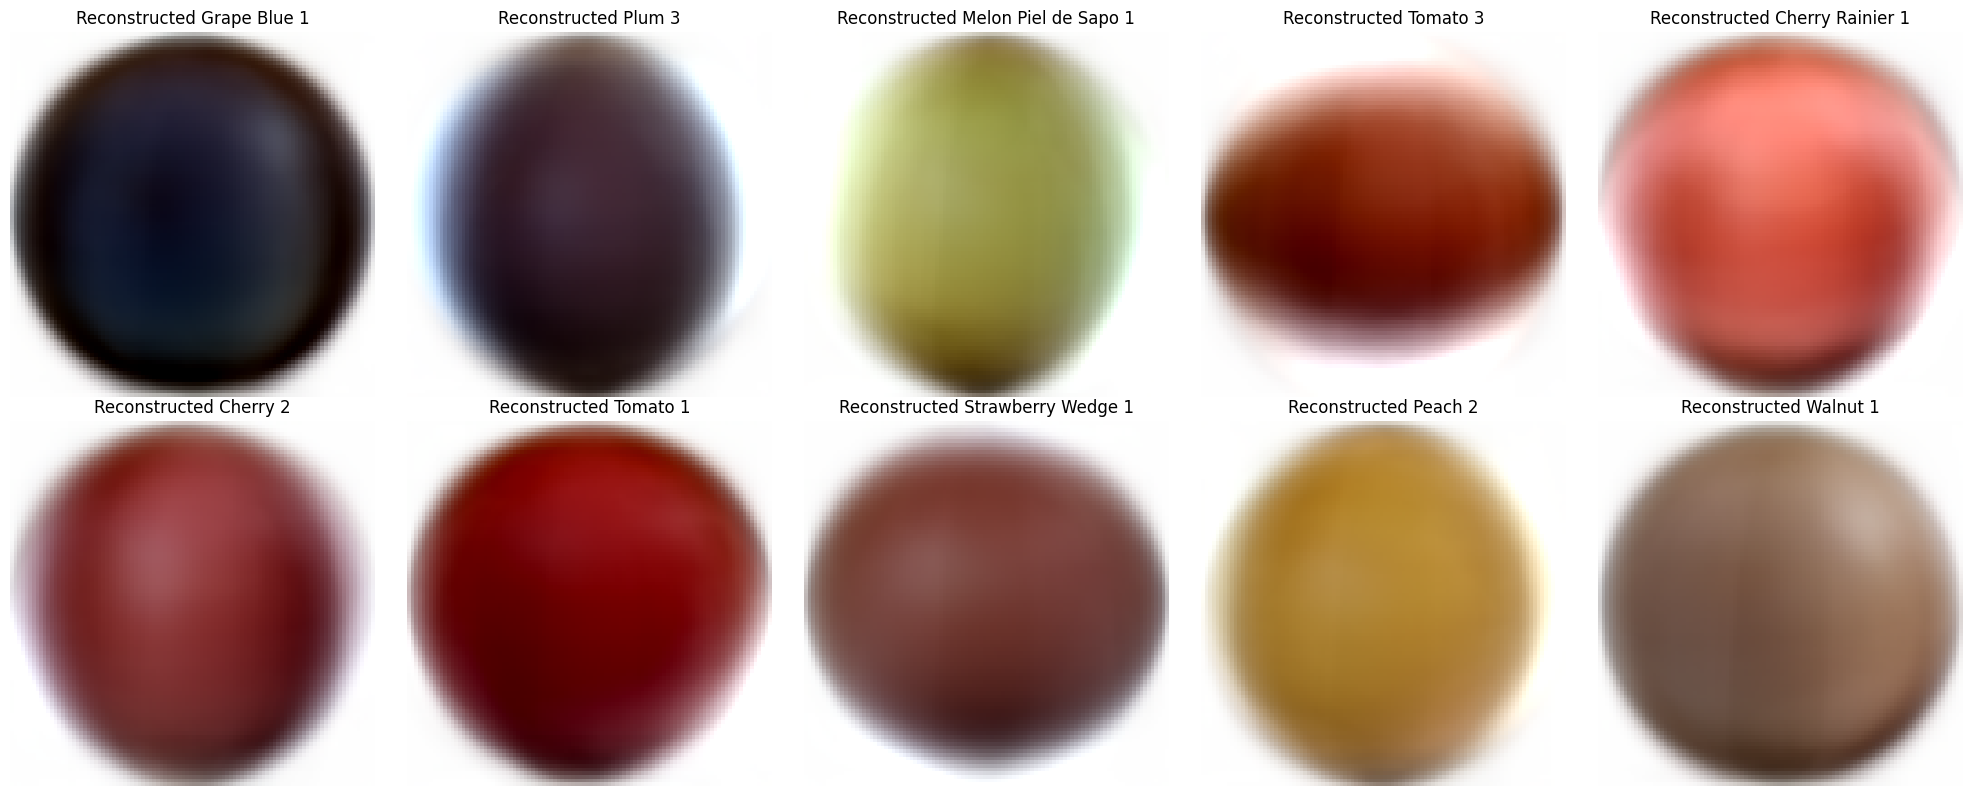

In [13]:
# pca = PCA(n_components=32)
# X_train_flat = train_generator[1][0].reshape(-1, img_size[0] * img_size[1] * 3)
# X_train_pca = pca.fit_transform(X_train_flat)
# Extragem toate imaginile din generator
# X_train = np.concatenate([train_generator[i][0] for i in range(len(train_generator))], axis=0)


# Reconstruim imaginile din setul de antrenament folosind PCA
reconstructed_images = []
for idx in image_indices:
    # Calculăm indicele global folosind batch-ul și poziția în lot
    global_index = len(train_generator[0][0]) * idx[0] + idx[1]
    
    # Reconstruim imaginea din PCA
    img_reconstructed = pca.inverse_transform(X_train_pca[global_index]).reshape(*img_size, 3)
    reconstructed_images.append(img_reconstructed)

# Vizualizare imagini reconstruite
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, img_reconstructed in enumerate(reconstructed_images):
    # Afișăm imaginile reconstruite
    axes[i].imshow(img_reconstructed.clip(0, 1))  # Clip pentru valori valide
    axes[i].set_title(f'Reconstructed {class_names[image_indices[i][2]]}')  # Numele clasei
    axes[i].axis('off')

plt.tight_layout()
plt.show()


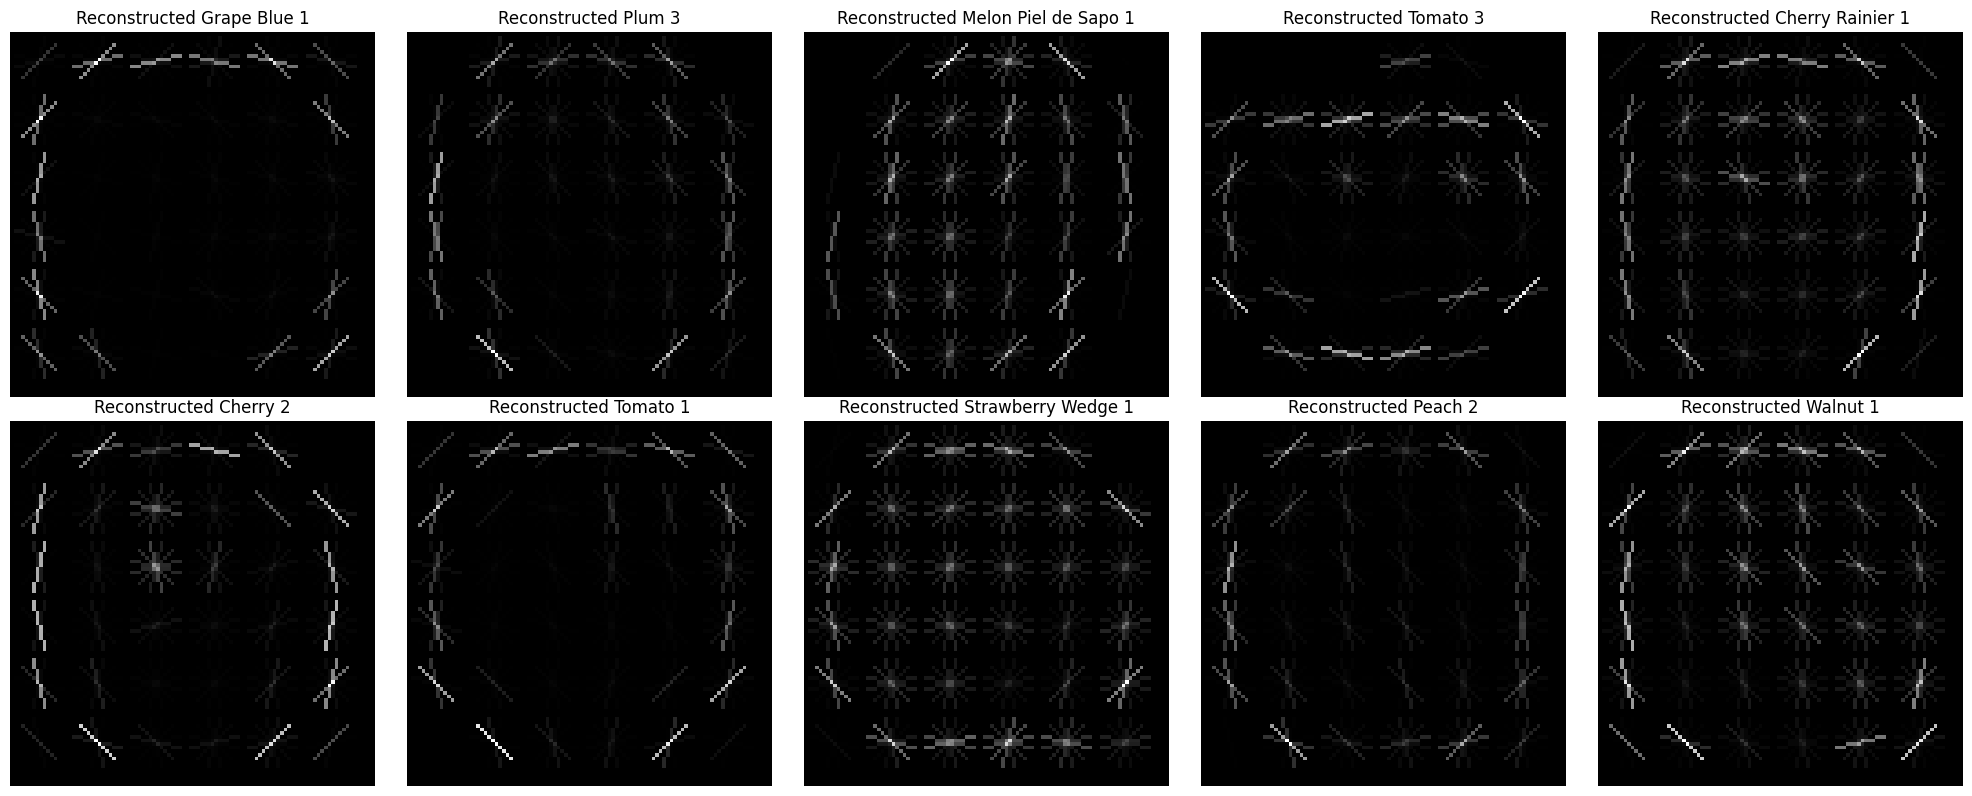

In [18]:
# Aplicăm HOG pe toate imaginile reconstruite
hog_features_list = []
hog_images_list = []

for img in original_images:
    hog_features, hog_image = hog(color.rgb2gray(img), orientations=6, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
    hog_features_list.append(hog_features)
    hog_images_list.append(hog_image)

# Vizualizare imagini HOG
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, hog_image in enumerate(hog_images_list):
    axes[i].imshow(hog_image, cmap='gray')
    axes[i].set_title(f'Reconstructed {class_names[image_indices[i][2]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif

scaler = StandardScaler()

scaler.fit(X_train_pca)

x_train_pca_standardized = scaler.transform(X_train_pca)
# print(x_train_pca.shape, x_train_pca_standardized.shape)

x_test_pca_standardized = scaler.transform(X_test_pca)
# print(x_test_pca.shape, x_test_pca_standardized.shape)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(X_train_hog)
x_test_hog_standardized = scaler_hog.transform(X_test_hog)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

variance_threshold = VarianceThreshold(threshold=1)
x_train_variance = variance_threshold.fit_transform(x_train_combined)
x_test_variance = variance_threshold.transform(x_test_combined)

print("Dimensiuni înainte și după Variance Threshold:")
print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")

Dimensiuni înainte și după Variance Threshold:
Dimensiuni train înainte: (70491, 226), după: (70491, 112)
Dimensiuni test înainte: (23619, 226), după: (23619, 112)


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
# Definirea modelului Logistic Regression
log_reg = LogisticRegression(max_iter=150)

# Definirea intervalelor de hiper-parametri pentru căutare
param_grid = {
    "C": np.logspace(-2, 2, 10),#np.logspace(-4, 4, 10),  # Regularizare (valori între 10^-4 și 10^4)
    "multi_class": ["ovr", "multinomial"]  # Metodologia de clasificare
}


random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, n_iter=10, random_state=42)

# Antrenarea și căutarea celor mai buni hiper-parametri
random_search.fit(x_train_variance, Y_train)

# Cel mai bun model și hiper-parametrii săi
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Predicția pe setul de testare combinat
y_pred_combined = best_model.predict(x_test_variance)

# Evaluarea performanței
accuracy_combined = accuracy_score(Y_test, y_pred_combined)
report_combined = classification_report(Y_test, y_pred_combined, target_names=class_names)

# Afișarea rezultatelor
print(f"Cei mai buni hiper-parametri: {best_params}")
print(f"Accuracy (Combined PCA + HOG): {accuracy_combined}")
print("Classification Report (Combined PCA + HOG):")
print(report_combined)

# Vizualizarea matricii de confuzie
ConfusionMatrixDisplay.from_estimator(best_model, x_test_variance, Y_test, display_labels=class_names)

C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py", line 1514, in fit
    accept_large_sparse=solver not in ["liblinear", "sag", "saga"],
  File "C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\base.p

ValueError: y should be a 1d array, got an array of shape (70491, 141) instead.